<a target="_blank" href="https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/w2024/Course_Notes/Week%205/intro_cross_validation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Cross validation

Example based on [CO2 data](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)

In [341]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import PolynomialFeatures

import matplotlib
import matplotlib.pyplot as plt

In [342]:
co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")

X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()
y = y - np.mean(y)
print(X.shape, y.shape)

(2225, 1) (2225,)


In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = X_train[::5], X_test[::5], y_train[::5], y_test[::5]

print(X_train.shape, y_train.shape, y_test.shape)


(334, 1) (334,) (112,)


In [344]:
def mse(prediction, target):
    return np.mean((prediction - target)**2)

In [345]:
def polynomial_features(X, deg):
    poly = PolynomialFeatures(deg)
    Phi = poly.fit_transform(X)
    return Phi

In [346]:
def polynomial_model_solver(X, y, deg, l=1E-2):
    Phi = polynomial_features(X, deg)
    A = Phi.T@Phi + l * np.eye(Phi.shape[1], Phi.shape[1])
    w = np.linalg.inv(A)@(Phi.T@y)
    return w

In [347]:
def lambda_solver(X_tr, y_tr,X_val,y_val, deg):
    l_grid = np.array([0., 1E-4, 1E-3, 1E-2, 1E-1, 0.15,0.2, 0.25, 0.3, 0.4,0.5, 1.])

    Phi_tr = polynomial_features(X_tr, deg)
    Phi_val = polynomial_features(X_val, deg)
    l_opt = 0
    error_min = np.inf
    for li in l_grid:
        w = polynomial_model_solver(X_tr, y_tr, deg, li)
        y_val_pred = Phi_val @ w
        error = mse(y_val_pred, y_val)
        if error < error_min:
            l_opt = li
            error_min = error
            
    return l_opt
        

In [348]:
print(np.floor(y_train.shape[0]/5))

66.0


In [349]:
deg = 10
n_folds = 5
kf = KFold(n_folds)

l_results = []
for train,val in kf.split(X_train):
    X_train_kfi, y_train_kfi = X_train[train], y_train[train]
    X_val_kfi, y_val_kfi = X_train[val], y_train[val]
    
    l_opt = lambda_solver(X_train_kfi,y_train_kfi,X_val_kfi,y_val_kfi, deg)
    l_results.append(l_opt)

l_results = np.array(l_results)
l_opt_cv = np.mean(l_results)
print('optimal lambda', l_opt_cv)

optimal lambda 0.20002000000000003


(11,)


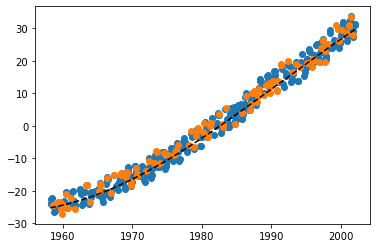

In [350]:
Phi_tr = polynomial_features(X_train,deg)
Phi_test = polynomial_features(X_test,deg)
w = polynomial_model_solver(X_train,y_train,deg,l_opt_cv)
print(w.shape)

x_grid = np.linspace(np.min(X),np.max(X),500)
Phi_grid = polynomial_features(x_grid[:,None],deg)
y_grid_pred = Phi_grid @ w

plt.figure(0)
plt.scatter(X_train,y_train)
plt.scatter(X_test,y_test)
plt.plot(x_grid,y_grid_pred,ls = '--',c = 'k', lw= 1.5)